# User Profiling with fuzzy preferences

Loading processed data...
Loaded 1682 fuzzy movies and 100000 ratings
Starting user profile creation...
Creating profiles for sample of 10 users
Created 10 user profiles
User profiling completed: 10 profiles created

Detailed analysis of first 3 users:

User 196:
  Ratings: 39
  Average Rating: 3.62
  Top 3 Genre Preferences:
    Comedy: 0.679
    Drama: 0.284
    Romance: 0.251

User 186:
  Ratings: 92
  Average Rating: 3.41
  Top 3 Genre Preferences:
    Thriller: 0.511
    Action: 0.295
    Drama: 0.241

User 22:
  Ratings: 128
  Average Rating: 3.35
  Top 3 Genre Preferences:
    Action: 0.518
    Comedy: 0.394
    Adventure: 0.245

User Preference Visualization


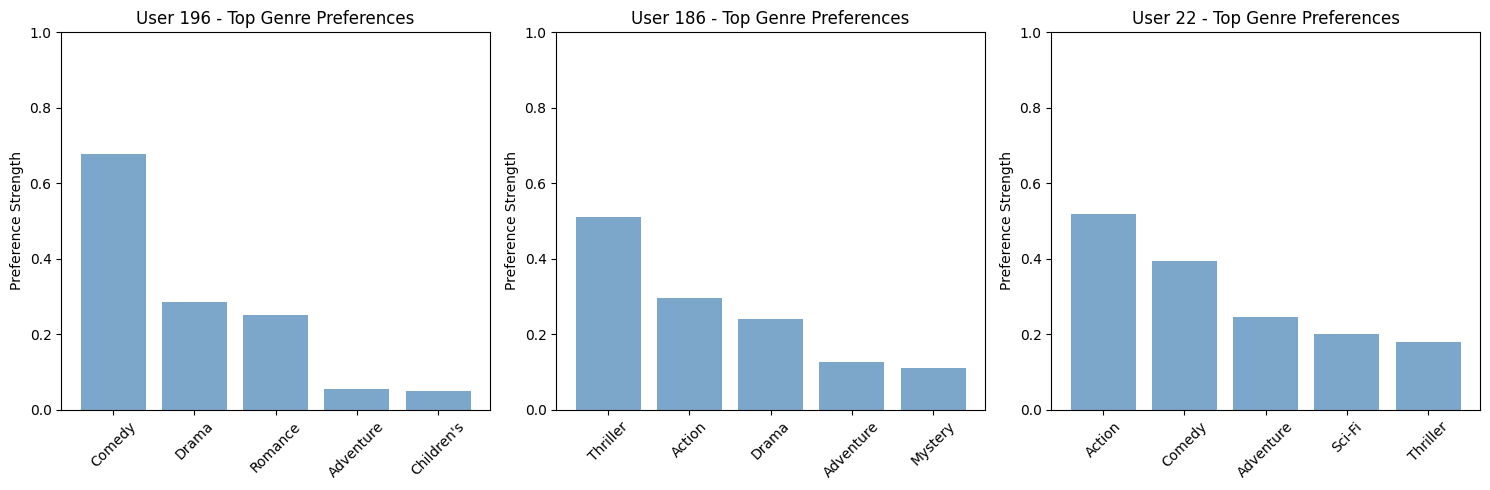


Overall User Preference Analysis
Most popular genres across all users (by coverage):

Genre Popularity Ranking:
Rank | Genre        | User Coverage | Avg Strength | Total Users
   1 | Drama        |  100.0%      |   0.325     |   10
   2 | Comedy       |   90.0%      |   0.276     |    9
   3 | Action       |   80.0%      |   0.216     |    8
   4 | Romance      |   80.0%      |   0.147     |    8
   5 | Thriller     |   80.0%      |   0.203     |    8
   6 | Adventure    |   50.0%      |   0.076     |    5
   7 | Mystery      |   20.0%      |   0.024     |    2
   8 | Sci-Fi       |   20.0%      |   0.031     |    2
   9 | War          |   20.0%      |   0.027     |    2
  10 | Children's   |   10.0%      |   0.015     |    1

Preference Strength Distribution


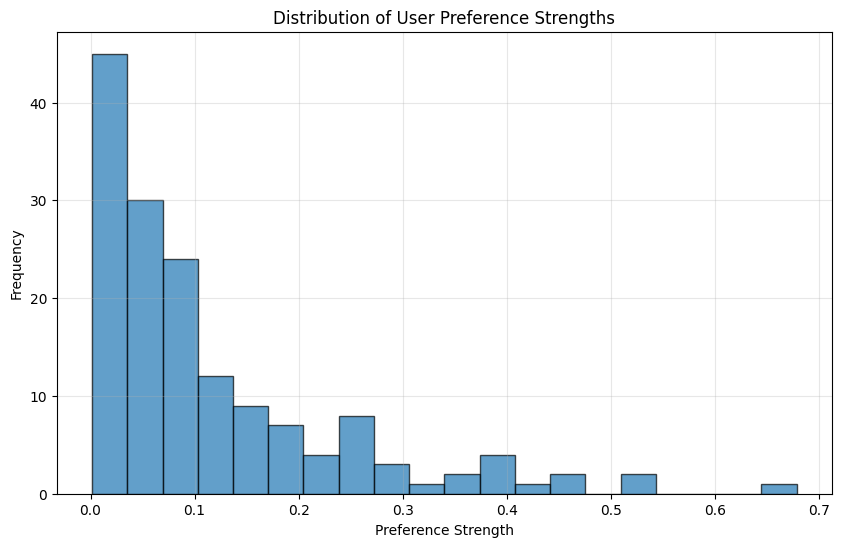

Preference strength statistics:
Mean: 0.115
Median: 0.073
Standard deviation: 0.123
Total preference instances: 155

User Segmentation Analysis
User segmentation results:
Drama Dominant: 0 users (0.0%)
Comedy Dominant: 1 users (10.0%)
Action Dominant: 1 users (10.0%)
Mixed Preferences: 8 users (80.0%)

Rating Behavior Analysis


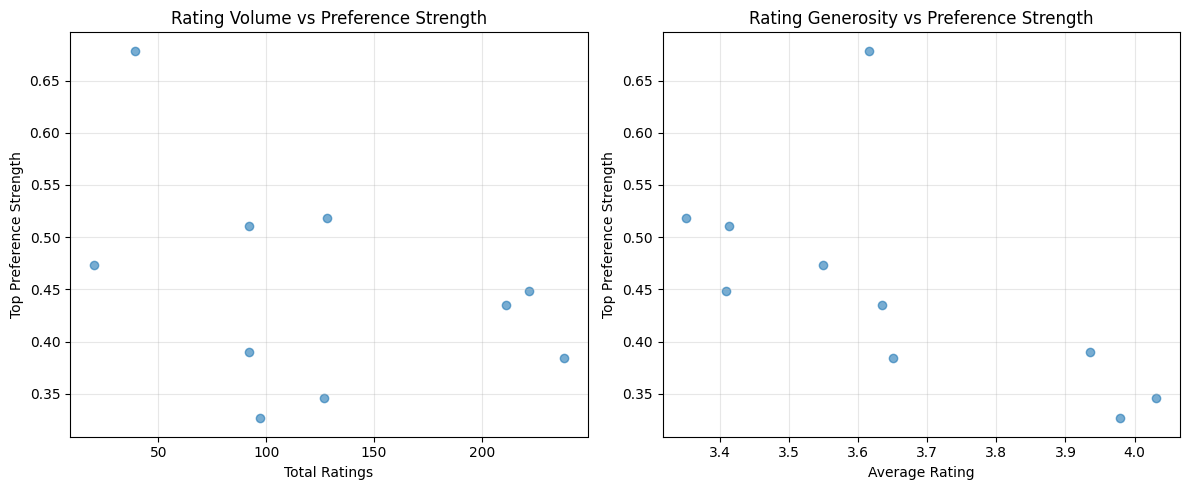

Correlation between rating volume and preference strength: -0.394
Correlation between rating generosity and preference strength: -0.621

Saving User Profiles
User profiles and analysis saved successfully

Fuzzy User Profiling Completed
Created 10 granular user profiles with fuzzy preferences
Achieved average preference strength of 0.115
Identified 18 distinct genre preference patterns

Average ratings per user: 126.6
Average user rating: 3.66
Preference instances per user: 15.5
Most popular genre: Drama (100.0% of users)


In [1]:
# Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import os

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

# Configuration and Data Loading
class ProjectConfig:
    """Project configuration"""
    PROJECT_ROOT = Path.cwd().parent
    DATA_DIR = PROJECT_ROOT / "data"
    PROCESSED_DATA_DIR = DATA_DIR / "processed"
    RESULTS_DIR = PROJECT_ROOT / "results"
    
    GENRES = [
        'unknown', 'Action', 'Adventure', 'Animation', 
        'Children\'s', 'Comedy', 'Crime', 'Documentary', 
        'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
        'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
        'Thriller', 'War', 'Western'
    ]
    
    @classmethod
    def setup_directories(cls):
        """Create necessary directories"""
        cls.RESULTS_DIR.mkdir(parents=True, exist_ok=True)

ProjectConfig.setup_directories()

print("Loading processed data...")
movies_fuzzy = pd.read_csv(ProjectConfig.PROCESSED_DATA_DIR / 'movies_fuzzy.csv')
ratings_df = pd.read_csv(ProjectConfig.PROCESSED_DATA_DIR / 'ratings_processed.csv')

print(f"Loaded {len(movies_fuzzy)} fuzzy movies and {len(ratings_df)} ratings")

# Fuzzy User Profiler Implementation
class FuzzyUserProfiler:
    """Create fuzzy user profiles based on movie ratings and fuzzy genres"""
    
    def __init__(self):
        self.config = ProjectConfig()
    
    def create_user_profile(self, user_id, ratings_df, fuzzy_movies_df):
        """Create fuzzy profile for a single user"""
        user_ratings = ratings_df[ratings_df['user_id'] == user_id]
        
        if len(user_ratings) == 0:
            print(f"No ratings found for user {user_id}")
            return None
        
        user_data = user_ratings.merge(fuzzy_movies_df, on='movie_id')
        user_profile = {genre: 0.0 for genre in self.config.GENRES if genre != 'unknown'}
        total_weight = 0
        
        for _, row in user_data.iterrows():
            rating = row['rating']
            weight = (rating - 1) / 4.0
            
            for genre in user_profile.keys():
                if genre in row:
                    user_profile[genre] += row[genre] * weight
            
            total_weight += weight
        
        if total_weight > 0:
            for genre in user_profile.keys():
                user_profile[genre] /= total_weight
        
        return {
            'user_id': user_id,
            'total_ratings': len(user_ratings),
            'average_rating': user_ratings['rating'].mean(),
            'profile': user_profile
        }
    
    def create_all_profiles(self, ratings_df, fuzzy_movies_df, sample_size=None):
        """Create fuzzy profiles for all users"""
        user_ids = ratings_df['user_id'].unique()
        
        if sample_size:
            user_ids = user_ids[:sample_size]
            print(f"Creating profiles for sample of {sample_size} users")
        else:
            print(f"Creating profiles for all {len(user_ids)} users")
        
        user_profiles = []
        
        for user_id in user_ids:
            profile = self.create_user_profile(user_id, ratings_df, fuzzy_movies_df)
            if profile:
                user_profiles.append(profile)
        
        print(f"Created {len(user_profiles)} user profiles")
        return user_profiles
    
    def get_top_genres(self, user_profile, n=5):
        """Get top N genres for a user profile"""
        profile_dict = user_profile['profile']
        sorted_genres = sorted(profile_dict.items(), key=lambda x: x[1], reverse=True)
        return sorted_genres[:n]
    
    def analyze_user_preferences(self, user_profiles):
        """Analyze overall user preference patterns"""
        genre_sums = {genre: 0.0 for genre in self.config.GENRES if genre != 'unknown'}
        genre_counts = {genre: 0 for genre in self.config.GENRES if genre != 'unknown'}
        
        for profile in user_profiles:
            for genre, value in profile['profile'].items():
                if value > 0.1:
                    genre_sums[genre] += value
                    genre_counts[genre] += 1
        
        genre_analysis = {}
        for genre in genre_sums.keys():
            if len(user_profiles) > 0:
                genre_analysis[genre] = {
                    'avg_strength': genre_sums[genre] / len(user_profiles),
                    'user_coverage': genre_counts[genre] / len(user_profiles),
                    'total_users': genre_counts[genre]
                }
        
        return genre_analysis

# Create User Profiles
print("Starting user profile creation...")
profiler = FuzzyUserProfiler()
user_profiles = profiler.create_all_profiles(ratings_df, movies_fuzzy, sample_size=10)

print(f"User profiling completed: {len(user_profiles)} profiles created")

# Individual User Profile Analysis
print("\nDetailed analysis of first 3 users:")

for i, profile in enumerate(user_profiles[:3]):
    user_id = profile['user_id']
    top_genres = profiler.get_top_genres(profile, n=3)
    
    print(f"\nUser {user_id}:")
    print(f"  Ratings: {profile['total_ratings']}")
    print(f"  Average Rating: {profile['average_rating']:.2f}")
    print(f"  Top 3 Genre Preferences:")
    
    for genre, strength in top_genres:
        print(f"    {genre}: {strength:.3f}")

# User Preference Visualization
print("\nUser Preference Visualization")

fig, axes = plt.subplots(1, min(3, len(user_profiles)), figsize=(15, 5))

if min(3, len(user_profiles)) == 1:
    axes = [axes]

for i, profile in enumerate(user_profiles[:3]):
    top_genres = profiler.get_top_genres(profile, n=5)
    genres = [g[0] for g in top_genres]
    strengths = [g[1] for g in top_genres]
    
    axes[i].bar(genres, strengths, color='steelblue', alpha=0.7)
    axes[i].set_title(f'User {profile["user_id"]} - Top Genre Preferences')
    axes[i].set_ylabel('Preference Strength')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Overall User Preference Analysis
print("\nOverall User Preference Analysis")
analysis = profiler.analyze_user_preferences(user_profiles)

print("Most popular genres across all users (by coverage):")
sorted_by_coverage = sorted(analysis.items(), key=lambda x: x[1]['user_coverage'], reverse=True)

print("\nGenre Popularity Ranking:")
print("Rank | Genre        | User Coverage | Avg Strength | Total Users")

for rank, (genre, stats) in enumerate(sorted_by_coverage[:10], 1):
    coverage_pct = stats['user_coverage'] * 100
    avg_strength = stats['avg_strength']
    total_users = stats['total_users']
    
    print(f"{rank:4} | {genre:12} | {coverage_pct:6.1f}%      | {avg_strength:7.3f}     | {total_users:4}")

# Preference Strength Distribution
print("\nPreference Strength Distribution")

all_strengths = []
for profile in user_profiles:
    for genre, strength in profile['profile'].items():
        if strength > 0:
            all_strengths.append(strength)

plt.figure(figsize=(10, 6))
plt.hist(all_strengths, bins=20, alpha=0.7, edgecolor='black')
plt.title('Distribution of User Preference Strengths')
plt.xlabel('Preference Strength')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Preference strength statistics:")
print(f"Mean: {np.mean(all_strengths):.3f}")
print(f"Median: {np.median(all_strengths):.3f}")
print(f"Standard deviation: {np.std(all_strengths):.3f}")
print(f"Total preference instances: {len(all_strengths)}")

# User Segmentation Analysis
print("\nUser Segmentation Analysis")

def segment_users_by_preferences(user_profiles):
    segments = {
        'drama_dominant': [],
        'comedy_dominant': [],
        'action_dominant': [],
        'mixed_preferences': []
    }
    
    for profile in user_profiles:
        top_genre, top_strength = profiler.get_top_genres(profile, n=1)[0]
        
        if top_strength > 0.5:
            if top_genre == 'Drama':
                segments['drama_dominant'].append(profile['user_id'])
            elif top_genre == 'Comedy':
                segments['comedy_dominant'].append(profile['user_id'])
            elif top_genre == 'Action':
                segments['action_dominant'].append(profile['user_id'])
            else:
                segments['mixed_preferences'].append(profile['user_id'])
        else:
            segments['mixed_preferences'].append(profile['user_id'])
    
    return segments

segments = segment_users_by_preferences(user_profiles)

print("User segmentation results:")
total_users = len(user_profiles)
for segment, users in segments.items():
    percentage = (len(users) / total_users) * 100
    print(f"{segment.replace('_', ' ').title()}: {len(users)} users ({percentage:.1f}%)")

# Rating Behavior vs Preference Strength Analysis
print("\nRating Behavior Analysis")

user_stats = []
for profile in user_profiles:
    top_strength = profiler.get_top_genres(profile, n=1)[0][1]
    user_stats.append({
        'user_id': profile['user_id'],
        'total_ratings': profile['total_ratings'],
        'avg_rating': profile['average_rating'],
        'top_preference_strength': top_strength
    })

stats_df = pd.DataFrame(user_stats)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(stats_df['total_ratings'], stats_df['top_preference_strength'], alpha=0.6)
plt.xlabel('Total Ratings')
plt.ylabel('Top Preference Strength')
plt.title('Rating Volume vs Preference Strength')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(stats_df['avg_rating'], stats_df['top_preference_strength'], alpha=0.6)
plt.xlabel('Average Rating')
plt.ylabel('Top Preference Strength')
plt.title('Rating Generosity vs Preference Strength')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

correlation_volume = stats_df['total_ratings'].corr(stats_df['top_preference_strength'])
correlation_generosity = stats_df['avg_rating'].corr(stats_df['top_preference_strength'])

print(f"Correlation between rating volume and preference strength: {correlation_volume:.3f}")
print(f"Correlation between rating generosity and preference strength: {correlation_generosity:.3f}")

# Save User Profiles and Analysis
print("\nSaving User Profiles")

try:
    profiles_data = []
    for profile in user_profiles:
        profile_row = {
            'user_id': profile['user_id'],
            'total_ratings': profile['total_ratings'],
            'average_rating': profile['average_rating']
        }
        for genre, strength in profile['profile'].items():
            profile_row[f'pref_{genre}'] = strength
        profiles_data.append(profile_row)
    
    profiles_df = pd.DataFrame(profiles_data)
    profiles_df.to_csv(ProjectConfig.RESULTS_DIR / 'user_profiles.csv', index=False)
    
    analysis_df = pd.DataFrame([
        {'metric': 'total_users', 'value': len(user_profiles)},
        {'metric': 'avg_ratings_per_user', 'value': stats_df['total_ratings'].mean()},
        {'metric': 'avg_preference_strength', 'value': np.mean(all_strengths)},
        {'metric': 'preference_diversity', 'value': len(all_strengths) / len(user_profiles)}
    ])
    analysis_df.to_csv(ProjectConfig.RESULTS_DIR / 'profiling_analysis.csv', index=False)
    
    print("User profiles and analysis saved successfully")
    
except Exception as e:
    print(f"Error saving data: {e}")

# Comprehensive Summary
print("\nFuzzy User Profiling Completed")

print(f"Created {len(user_profiles)} granular user profiles with fuzzy preferences")
print(f"Achieved average preference strength of {np.mean(all_strengths):.3f}")
print(f"Identified {len(analysis)} distinct genre preference patterns")

print(f"\nAverage ratings per user: {stats_df['total_ratings'].mean():.1f}")
print(f"Average user rating: {stats_df['avg_rating'].mean():.2f}")
print(f"Preference instances per user: {len(all_strengths) / len(user_profiles):.1f}")

most_popular_genre = sorted_by_coverage[0][0] if sorted_by_coverage else "N/A"
most_popular_coverage = sorted_by_coverage[0][1]['user_coverage'] * 100 if sorted_by_coverage else 0

print(f"Most popular genre: {most_popular_genre} ({most_popular_coverage:.1f}% of users)")